In [1]:
import torch
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm
from sklearn.linear_model import LinearRegression as SklearnLR
from concrete import fhe
# from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer
# from concrete.ml.sklearn import SGDClassifier
from concrete.ml.sklearn import LinearRegression as ZamaLR

from sklearn.metrics import confusion_matrix

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data si este procesat in notebook-ul data/process_data.ipynb pentru usurinta.

Codul se poate rula integral prin optiunea "Run All" a notebook-ului

In [2]:
def load_data(path):
    saved_data = torch.load(path,weights_only=True)
    x_train = saved_data['train_data']
    x_test = saved_data['test_data']
    y_train = saved_data['train_labels']
    y_test = saved_data['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

Datele primite au valori mult prea diferite, de aceea ele trebuie normalizate pentru ca toate caracteristicile sa fie in intervale compatibile unele cu altele (i.e., varsta este in intervalul $[20, 100]$ si genul este in intervalul $[0, 1]$ $\Rightarrow$ ele trebuie aduse la un interval comun pentru a lucra cu ele).


In [3]:
def normalize_data(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


Setul de date este destul de mare, pentru a lucra mai usor dpdv al timpului si al memoriei o sa lucram cu un subset suficent de mare sa obtinem rezultate, dar suficient de mic pentru a putea fi procesat in limite decente de timp si memorie

In [4]:
x_train,x_test,y_train,y_test = load_data('../../data/date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalize_data(x_train,x_test,y_train,y_test)
x_train,x_test,y_train,y_test= x_train[:1000],x_test[:700],y_train[:1000],y_test[:700]
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


In [5]:
t_start = time.perf_counter()
sklearn_model = SklearnLR().fit(x_train,y_train)
t_end = time.perf_counter()

print(f"Antrenarea modelului pe datele clare cu biblioteca Sklearn a durat: {(t_end - t_start):.20f} secunde")

Antrenarea modelului pe datele clare cu biblioteca Sklearn a durat: 0.01273228000036397134 secunde


In [9]:
def save_model(model, file_path):
    pickle.dump(model, open(file_path, "wb"))

In [6]:
def metrics_on_clear_data(model, x, y, biblioteca):
    t_start = time.perf_counter()
    predictions = model.predict(x)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")
    r2 = r2_score(y, predictions)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, predictions)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title(f'Model antrenat pe date clare-Preziceri pe date clare {biblioteca}', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig(f"../../plots/liniar_regression/li_r_trained_on_clear_data_predictions_on_clear_data_{biblioteca}.png")
    plt.show()

Predictiile pe testul de date necriptate au durat:0.00084491600000546896 secunde
R^2 Score = 0.9425
MSE = 0.0595


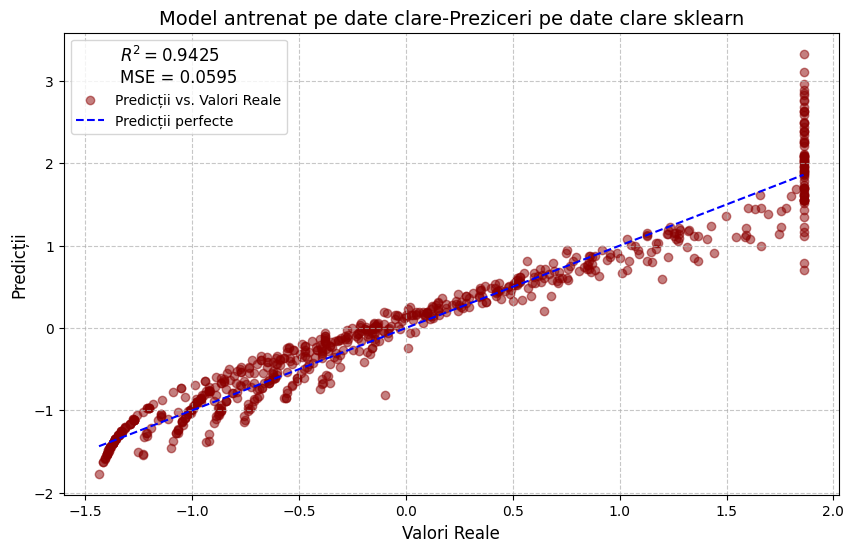

In [7]:
metrics_on_clear_data(sklearn_model,x_test,y_test, 'sklearn')

In [18]:
t_start = time.perf_counter()
zama_model = ZamaLR(n_bits=8)
zama_model.fit(x_train, y_train)
t_end = time.perf_counter()

print(f"Antrenarea modelului pe datele clare cu biblioteca Zama a durat: {(t_end - t_start):.20f} secunde")

Antrenarea modelului pe datele clare cu biblioteca Zama a durat: 0.05624708799996369635 secunde


Predictiile pe testul de date necriptate au durat:0.00106093700014753267 secunde
R^2 Score = 0.9430
MSE = 0.0589


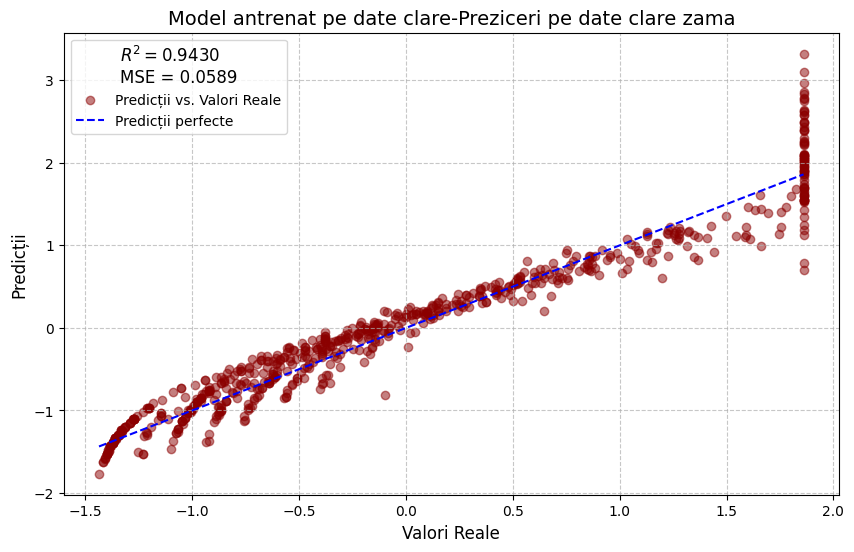

In [26]:
metrics_on_clear_data(zama_model,x_test,y_test, 'zama')

In [ ]:
def metrics_on_encrypted_data(model, x_test,x_train, y, biblioteca):
    #generam criptocontextul
    crypto_context = model.compile(x_train)
    crypto_context.client.keygen(force=False)
    t_start = time.perf_counter()
    predictions = model.predict(x_test, fhe="execute")
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date criptate au durat:{(t_end - t_start):.20f} secunde")
    r2 = r2_score(y, predictions)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, predictions)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, predictions, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title(f'Model antrenat pe date clare-Preziceri pe date criptate {biblioteca}', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig(f"../../plots/liniar_regression/li_r_trained_on_clear_data_predictions_on_enc_data_{biblioteca}.png")
    plt.show()

Predictiile pe testul de date criptate au durat:6.87411916600012773415 secunde
R^2 Score = 0.9430
MSE = 0.0589


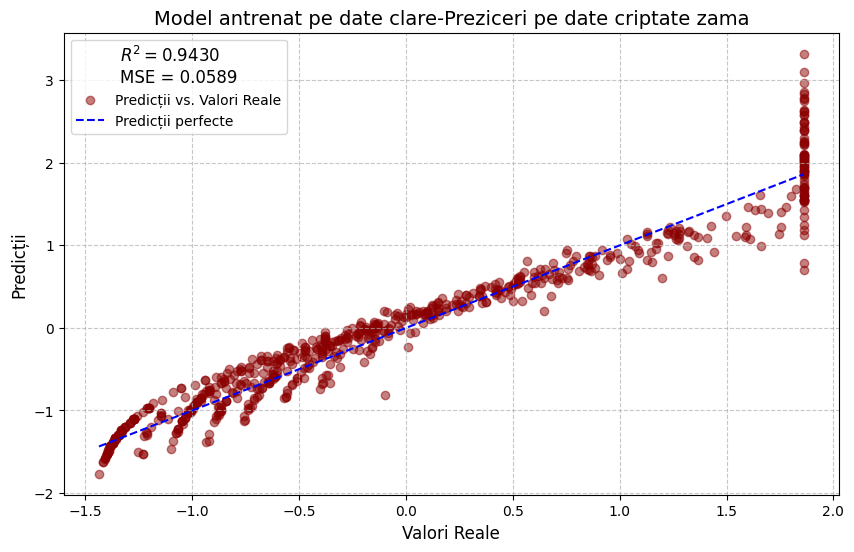

In [25]:
metrics_on_encrypted_data(zama_model,x_test,x_train, y_test, "zama")